# ADX in Action

In [1]:
# import packages
import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

/anaconda3/envs/fx/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
ticker = "AAPL"
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(364)
ohlcv = pdr.get_data_yahoo(ticker, start_date, end_date)

In [34]:
def get_avg_true_range(data, n):
    df = get_true_range(data)
    df['ATR'] = df['TR'].rolling(n).mean()
    output = df.drop(['HL', 'HPC', 'LPC'], axis=1)
    output.dropna(inplace=True)
    return output
    

In [3]:
def get_adx(data, n):
    """Function to calculate ADX."""
    def get_true_range(data):
        if isinstance(data, pd.DataFrame):
            df = data.copy()
        else:
            raise TypeError("Data must be a Pandas DataFrame.")
        df['HL'] = np.abs(df['High'] - df['Low'])
        df['HPC'] = np.abs(df['High'] - df['Adj Close'].shift(1))
        df['LPC'] = np.abs(df['Low'] - df['Adj Close'].shift(1))
        df['TR'] = df[['HL', 'HPC', 'LPC']].max(axis=1, skipna=False)
        return df
    
    # True Range
    df = get_true_range(data)
    # DM plus & minus
    high_diff = df['High']-df['High'].shift(1)
    low_diff = df['Low'].shift(1)-df['Low']
    df['DM+'] = np.where(high_diff > low_diff, high_diff, 0)
    df['DM+'] = np.where(df['DM+'] < 0, 0, df['DM+'])
    df['DM-'] = np.where(low_diff > high_diff, low_diff, 0)
    df['DM-'] = np.where(df['DM-'] < 0, 0, df['DM-'])
    # Populate TR_{n}, DM+_{n} & DM-_{n}
    TR_n, DMplus_n, DMminus_n = [], [], []
    TR = df['TR'].values
    DMplus = df['DM+'].values
    DMminus = df['DM-'].values
    for i in range(df.shape[0]):
        if i < n:
            TR_n.append(np.nan)
            DMplus_n.append(np.nan)
            DMminus_n.append(np.nan)
        elif i == n:
            TR_n.append(df['TR'].rolling(n).sum().tolist()[n])
            DMplus_n.append(df['DM+'].rolling(n).sum().tolist()[n])
            DMminus_n.append(df['DM-'].rolling(n).sum().tolist()[n])
        elif i > n:
            TR_n.append(TR_n[i-1] - (TR_n[i-1]/14) + TR[i])
            DMplus_n.append(DMplus_n[i-1] - (DMplus_n[i-1]/n) + DMplus[i])
            DMminus_n.append(DMminus_n[i-1] - (DMminus_n[i-1]/n) + DMminus[i])
        else:
            raise ValueError(f"i ({i}) was not ><= relative to n ({n})")
    df['TR_n'] = TR_n
    df['DM+_n'] = DMplus_n
    df['DM-_n'] = DMminus_n
    
    df['DI+_n'] = 100 * (df['DM+_n'] / df['TR_n'])
    df['DI-_n'] = 100 * (df['DM-_n'] / df['TR_n'])
    df['DIdiff'] = np.abs(df['DI+_n'] - df['DI-_n'])
    df['DIsum'] = df['DI+_n'] + df['DI-_n']
    df['DX'] = 100 * (df['DIdiff'] / df['DIsum'])
    ADX = []
    DX = df['DX'].values
    for j in range(df.shape[0]):
        if j < 2 * n - 1:
            ADX.append(np.nan)
        elif j == 2 * n - 1:
            ADX.append(df['DX'][j - n + 1: j+1].mean())
        elif j > 2 * n - 1:
            ADX.append(((n-1) * ADX[j - 1] + DX[j]) / n)
    return ADX

In [4]:
adx_maison = get_adx(data=ohlcv, n=14)

In [5]:
adx_maison

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 44.20574918985356,
 44.90984770269681,
 45.02556835119094,
 43.82951313500161,
 42.6059792833437,
 40.10023991231541,
 37.31424070002705,
 34.836911889238756,
 32.495907780422485,
 30.48142761961117,
 28.666733849337792,
 26.691860133509266,
 25.717310378269385,
 24.81237131983235,
 24.106472018752296,
 23.497197376141706,
 22.931442350860443,
 21.616106691264427,
 20.79231287008053,
 20.159755534684784,
 18.869040701369958,
 18.775209435815547,
 18.688080403515023,
 18.877392364692252,
 19.185630637447225,
 18.141586297450125,
 17.199196532863827,
 16.863749217460885,
 16.707355540381815,
 16.562132840236966,
 16.88679705410535,
 17.0044581504963,
 17.025521695258835,
 17.26424905457309,
 16.940221050023975,
 16.8631304747196,
 17.282595484249136,
 17.740607857127657,
 17.95453148531126,
 18.31108498388042,
 18.9329680453495

In [6]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def get_ADX_2(DF,n):
    "function to calculate ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    return ADX

In [7]:
adx_cours = get_ADX_2(ohlcv, 14)

In [8]:
adx_cours

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 44.20574918985356,
 44.90984770269681,
 45.02556835119094,
 43.82951313500161,
 42.6059792833437,
 40.10023991231541,
 37.31424070002705,
 34.836911889238756,
 32.495907780422485,
 30.48142761961117,
 28.666733849337792,
 26.691860133509266,
 25.717310378269385,
 24.81237131983235,
 24.106472018752296,
 23.497197376141706,
 22.931442350860443,
 21.616106691264427,
 20.79231287008053,
 20.159755534684784,
 18.869040701369958,
 18.775209435815547,
 18.688080403515023,
 18.877392364692252,
 19.185630637447225,
 18.141586297450125,
 17.199196532863827,
 16.863749217460885,
 16.707355540381815,
 16.562132840236966,
 16.88679705410535,
 17.0044581504963,
 17.025521695258835,
 17.26424905457309,
 16.940221050023975,
 16.8631304747196,
 17.282595484249136,
 17.740607857127657,
 17.95453148531126,
 18.31108498388042,
 18.9329680453495

In [9]:
adx_maison[-1] == adx_cours[-1]

True

In [10]:
adx_maison[-2]

21.969895077719908

In [11]:
adx_cours[-2]

21.969895077719908

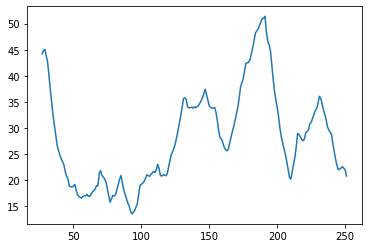

In [12]:
plt.plot(adx_maison)

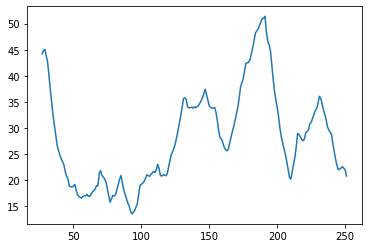

In [13]:
plt.plot(adx_cours)